# Credit Card Fraud Detection

In [1]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualization'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, recall_score
from sklearn import set_config;  set_config(display = 'diagram')
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, recall_score

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision



2025-01-20 21:03:15.205220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-20 21:03:15.262300: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Load data
df = pd.read_csv("creditcard.csv")

In [3]:
# Select data
X = df.drop(columns=['Class'],axis=1).values
y = df['Class'].values

## 1. Rebalancing classes

In [4]:
# Let's check class balance
pd.Series(y).value_counts(normalize=True)

0    0.998273
1    0.001727
Name: proportion, dtype: float64

☝️ in this `fraud detection` dataset, **the classes are extremely imbalanced**:
* 99.8 % of normal transactions
* 0.2 % of fraudulent transactions

**We are going to rebalance the dataset**


In [5]:
# Train test split before any resampling to keep real test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3,stratify=y_train)

In [7]:
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (139554, 30)
y_train.shape = (139554,)
X_val.shape = (59810, 30)
y_val.shape = (59810,)
X_test.shape = (85443, 30)
y_test.shape = (85443,)


In [8]:
# How many "fraud" samples are there in each split?
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))

print("-"*100)

print(f"There are {pd.Series(y_train).value_counts()[1]} fraudulent transactions in the train set")
print(f"There are {pd.Series(y_val).value_counts()[1]} fraudulent transactions in the val set")
print(f"There are {pd.Series(y_test).value_counts()[1]} fraudulent transactions in the test set")

241
103
148
----------------------------------------------------------------------------------------------------
There are 241 fraudulent transactions in the train set
There are 103 fraudulent transactions in the val set
There are 148 fraudulent transactions in the test set


In [9]:
# Sampling strategies
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.33)

In [10]:

# Pipelining the two strategies
steps =  [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
pipeline

Pipeline(steps=[('o', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.33))])

In [11]:
# Rebalance the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"X_train_resampled.shape = {X_train_resampled.shape}")
print(f"y_train_resampled.shape = {y_train_resampled.shape}")

X_train_resampled.shape = (56146, 30)
y_train_resampled.shape = (56146,)


In [12]:
# Reshuffle the resampled data just to be sure
stacked_resampled_data = np.hstack([X_train_resampled, y_train_resampled.reshape(-1,1)])
np.random.shuffle(stacked_resampled_data)

X_train_resampled = stacked_resampled_data[:,:30]
y_train_resampled = stacked_resampled_data[:,-1]

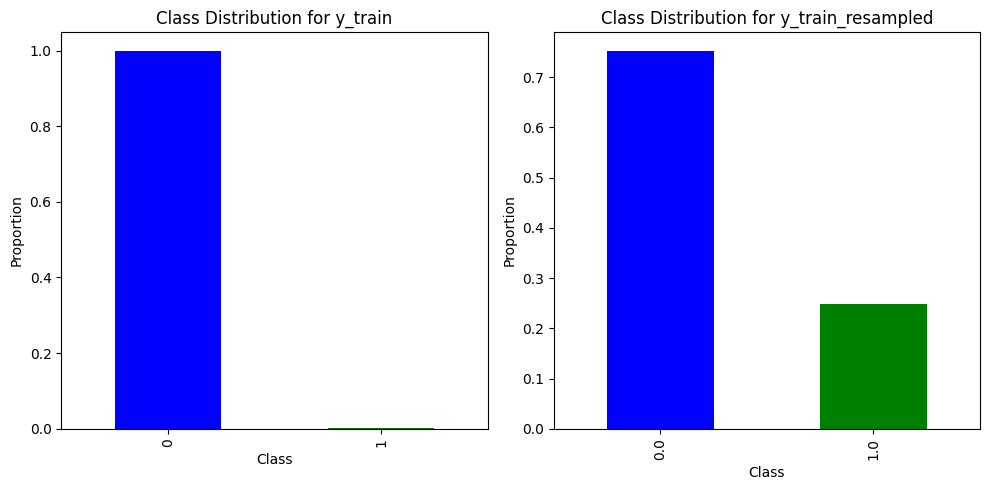

In [13]:
# Calculate class distribution for y_train
class_distribution_train = pd.Series(y_train).value_counts(normalize=True)

# Calculate class distribution for y_train_resampled
class_distribution_resampled = pd.Series(y_train_resampled).value_counts(normalize=True)

# Plotting
plt.figure(figsize=(10, 5))

# Bar chart for y_train
plt.subplot(1, 2, 1)
class_distribution_train.plot(kind='bar', color=['blue', 'green'])
plt.title('Class Distribution for y_train')
plt.xlabel('Class')
plt.ylabel('Proportion')

# Bar chart for y_train_resampled
plt.subplot(1, 2, 2)
class_distribution_resampled.plot(kind='bar', color=['blue', 'green'])
plt.title('Class Distribution for y_train_resampled')
plt.xlabel('Class')
plt.ylabel('Proportion')

plt.tight_layout()
plt.show()

In [14]:
print(X_train_resampled.shape)
print(X_val.shape)

(56146, 30)
(59810, 30)


## 2. Neural Network iterations



In [15]:
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

2025-01-20 21:03:17.438843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:


def init_model():
    input_shape = X_train_resampled.shape[1:]
    normalizer = Normalization()
    normalizer.adapt(X_train_resampled)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

### Regularized model

In [17]:
model = init_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 30)               61        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                992       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                        

In [18]:
es = EarlyStopping(
    patience=10,
    monitor='val_recall', # We want to detect fraudulent transactions!
    restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=64, # Large enough to get a decent chance of containing fraudulent transactions 
                    callbacks=[es], shuffle=True)

Epoch 1/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5916 - recall: 0.5925 - precision: 0.4777 - prc: 0.6286 - val_loss: 0.2984 - val_recall: 0.7961 - val_precision: 0.4767 - val_prc: 0.6505
Epoch 2/100
878/878 [==============================] - 2s 2ms/step - loss: 0.2809 - recall: 0.7119 - precision: 0.9200 - prc: 0.8918 - val_loss: 0.0501 - val_recall: 0.8932 - val_precision: 0.5644 - val_prc: 0.6975
Epoch 3/100
878/878 [==============================] - 2s 2ms/step - loss: 0.1750 - recall: 0.7866 - precision: 0.9664 - prc: 0.9472 - val_loss: 0.0227 - val_recall: 0.9029 - val_precision: 0.3370 - val_prc: 0.7296
Epoch 4/100
878/878 [==============================] - 2s 2ms/step - loss: 0.1392 - recall: 0.8199 - precision: 0.9742 - prc: 0.9634 - val_loss: 0.0192 - val_recall: 0.9029 - val_precision: 0.2548 - val_prc: 0.7353
Epoch 5/100
878/878 [==============================] - 2s 2ms/step - loss: 0.1178 - recall: 0.8406 - precision: 0.9775 - prc: 0.9722 - val_l

In [19]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

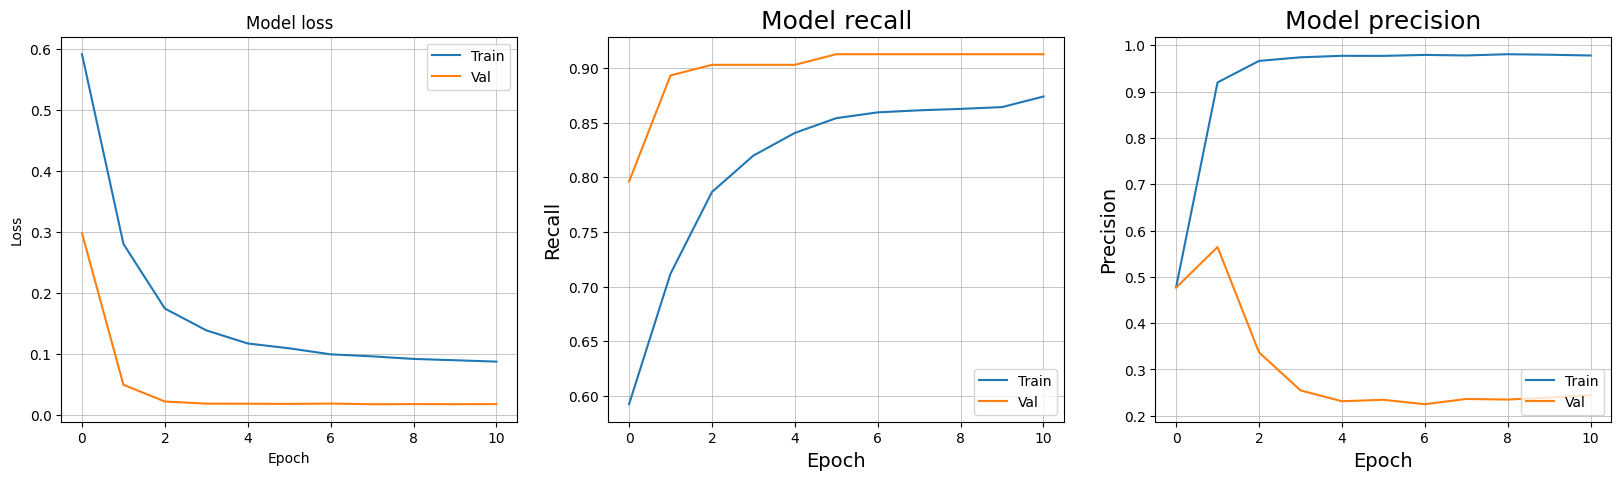

In [20]:
plot_loss_precision_recall_curve(history)

By optimizing on the recall, we sacrified the precision!

However our goal is to detect all the frauds to be detected.

## 3. Score model on the Test set



In [21]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

{'loss': 0.2980104684829712,
 'recall': 0.7027027010917664,
 'precision': 0.47488585114479065,
 'prc': 0.6021084785461426}

In [22]:
y_pred_proba = model.predict(X_test)

2671/2671 [==============================] - 2s 615us/step


In [23]:
threshold = 0.50 # 50% 

y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )

### Confusion Matrix

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_binary)
cm

array([[85180,   115],
       [   44,   104]])

Text(0.5, 25.722222222222214, 'Predicted label')

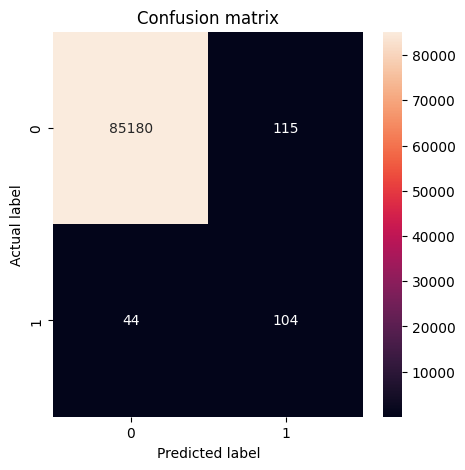

In [25]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [31]:
recall = recall_score(y_test, y_pred_binary)
print(f' Recall {recall}, This means that 70% of actual fraudulent transactions are detected by the model, while 30% are missed.')

 Recall 0.7027027027027027, This means that 70% of actual fraudulent transactions are detected by the model, while 30% are missed.


- True Negatives (TN): 85,180 Non-fraudulent transactions correctly identified as non-fraudulent.

- False Positives (FP): 115 Non-fraudulent transactions incorrectly identified as fraudulent.

- False Negatives (FN): 44 Fraudulent transactions incorrectly identified as non-fraudulent.

- True Positives (TP): 104 Fraudulent transactions correctly identified as fraudulent.
